In [1]:
import pandas as pd
import re
import itertools
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import igraph as ig
from IPython.display import HTML
import multiprocessing
import pickle as pkl
import random
from collections import Counter
import os
import subprocess
from scipy.stats import mannwhitneyu
import ete3
from copy import deepcopy
from math import ceil

ncbi = ete3.NCBITaxa()
%run assess_connections-functions.ipynb

%cd ~/work/eggNOG/

/nobackup1b/users/thiberio/eggNOG


In [2]:
sampled_genomes = pd.read_csv('../kelsey/genomes.tab',
                              sep='\t',
                              index_col=0)

lineages = pd.DataFrame()
for taxid in sampled_genomes.species_taxid.unique():
    if pd.isna(taxid):
        continue
    lineages = lineages.append({tax_rank: tmp_taxid 
                                 for tmp_taxid, tax_rank in ncbi.get_rank(ncbi.get_lineage(taxid)).items()},
                                ignore_index=True)
lineages = lineages.reindex(columns=['class', 'family',  'genus', 'phylum',
                                     'order', 'species', 'superkingdom']).copy()
lineages = lineages.query('superkingdom == 2').copy()

In [3]:
sampled_phyla = [phylum for phylum in lineages.phylum.unique().astype(int) if phylum > 0]

In [4]:
working_groups  = pd.read_parquet('working_eggNOG_groups.parquet', engine='fastparquet')
working_trees   = pd.read_parquet('working_eggNOG_trees.parquet' , engine='fastparquet')
eggNOG_taxonomy = pd.read_parquet('eggNOG_taxonomy.parquet'      , engine='fastparquet')

In [5]:
with open('all_results.pkl', 'rb') as _:
    phylum_connections = pkl.load(_)

In [6]:
regular_connections     = []
significant_connections = []

for group_id, group_clusters in phylum_connections:
    if not group_clusters:
        continue
    
    for cluster_num, cluster_data in group_clusters.items():

        for ref_phylum, phyla_dists in cluster_data.items():
            
            if not phyla_dists['df'].shape[0]:
                continue

            closest_phylum = phyla_dists['df'].iloc[0, 0]
            if not closest_phylum in sampled_phyla:
                continue

            if phyla_dists['significant']:
                significant_connections.append( (ref_phylum,
                                                 phyla_dists['df'].iloc[0, 0],
                                                 phyla_dists['df'].iloc[0, 1], 
                                                 '%s#%i' % (group_id, cluster_num)) )

                for index, tmp_series in phyla_dists['df'].iloc[1:, :].iterrows():
                    if tmp_series.phylum in sampled_phyla:
                        regular_connections.append( (ref_phylum,
                                                         tmp_series.phylum,
                                                         tmp_series['median'], 
                                                         '%s#%i' % (group_id, cluster_num)) )

            else:
                for index, tmp_series in phyla_dists['df'].iterrows():
                    if tmp_series.phylum in sampled_phyla:
                        regular_connections.append( (ref_phylum,
                                                         tmp_series.phylum,
                                                         tmp_series['median'], 
                                                         '%s#%i' % (group_id, cluster_num)) )

significant_df = pd.DataFrame(data=significant_connections, columns=['source', 'target', 'distance', 'group'])
regular_df     = pd.DataFrame(data=regular_connections,     columns=['source', 'target', 'distance', 'group'])

significant_df.dropna(how='any', inplace=True)
regular_df.dropna(    how='any', inplace=True)

In [7]:
closest_relation_freq = pd.DataFrame(columns=sampled_phyla)

for phylum in sampled_phyla:
    tmp = significant_df.query('source==@phylum').target.value_counts()
    tmp.name = phylum
    closest_relation_freq = closest_relation_freq.append(tmp)

phylum_names                    = {phylum:ncbi.translate_to_names([int(phylum)])[0] 
                                   for phylum in sampled_phyla}

closest_relation_freq.drop(columns=[1798710], index=[1798710], inplace=True)
closest_relation_freq.rename(columns=phylum_names, index=phylum_names, inplace=True)
closest_relation_freq = closest_relation_freq.stack().reset_index()

closest_relation_freq.rename(columns={'level_0':'reference', 
                                      'level_1':'target', 
                                      0        :'count'}, 
                             inplace=True)

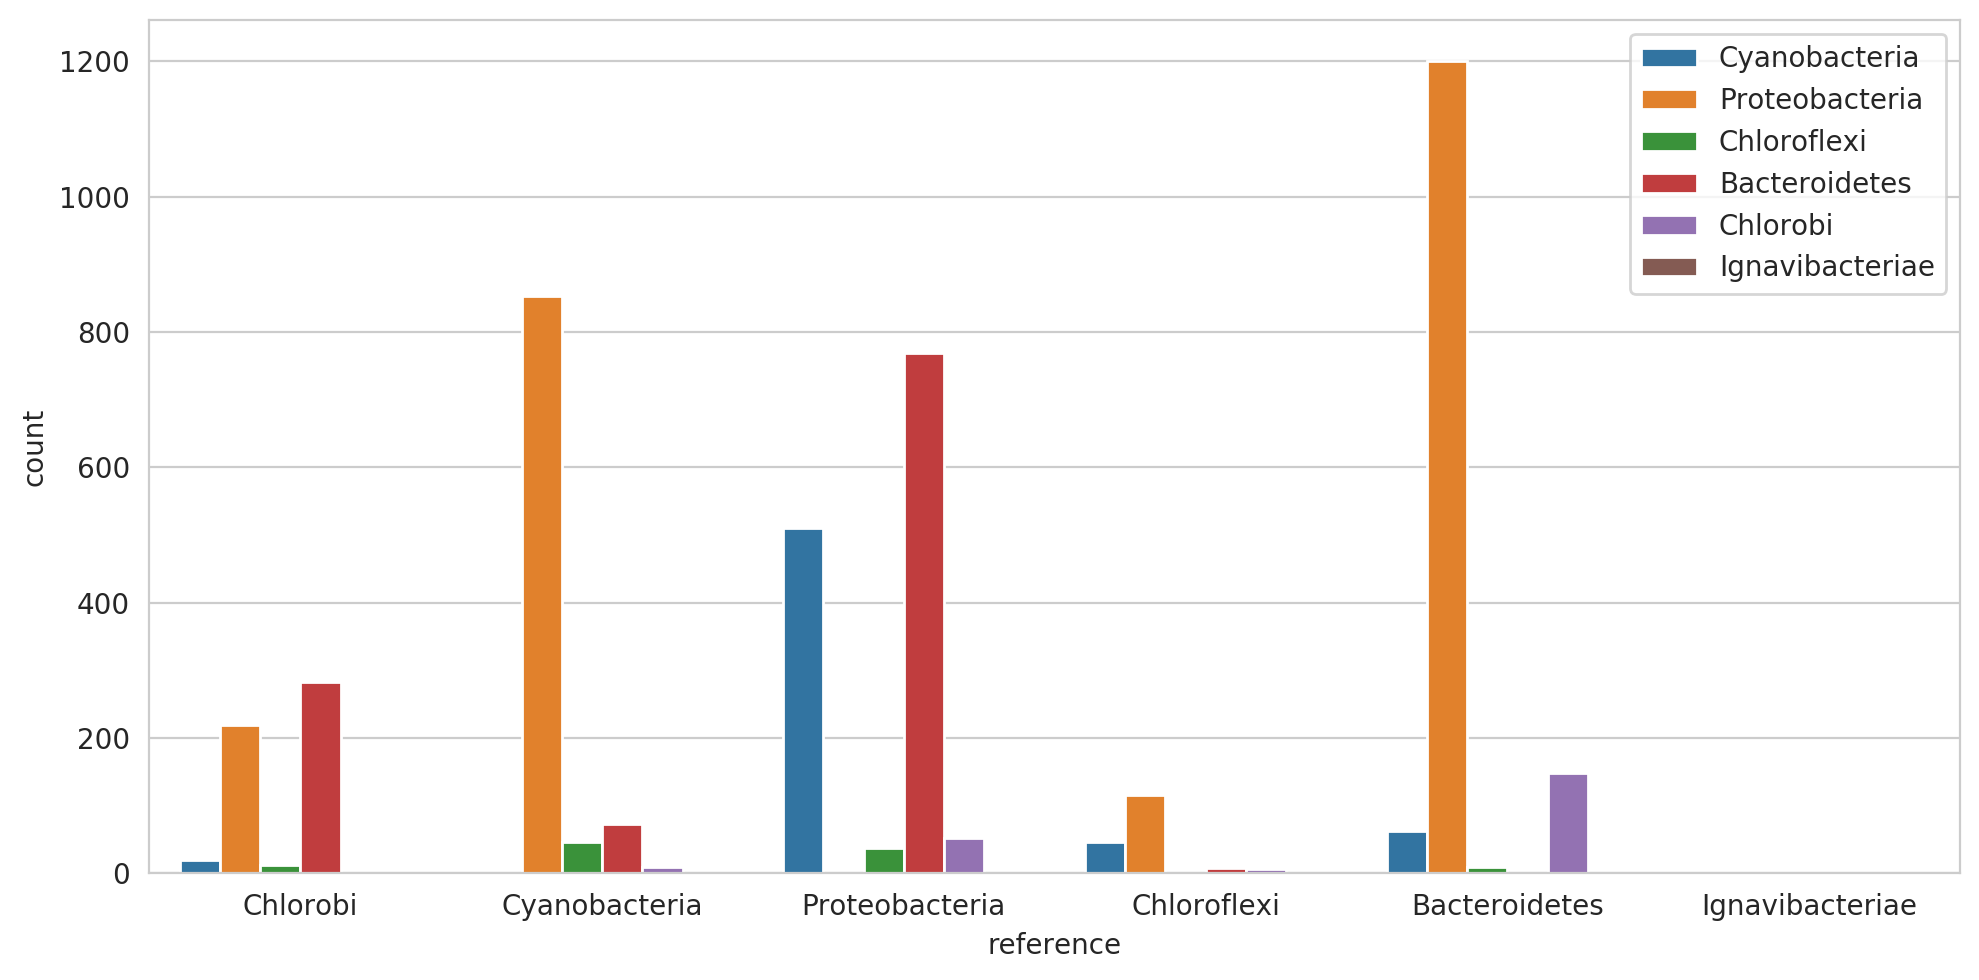

In [8]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(dpi=200, figsize=(10, 5))
    sns.barplot(x='reference', y='count', hue='target', data=closest_relation_freq, ax=ax)
    ax.legend(loc=1)
    fig.tight_layout();

In [9]:
#
# fastTree
#

def assess_transfers_between_phyla(related_phyla):
# related_phyla = (1090, 1117)

    candidates    = set(significant_df.query('source=="%i" and target=="%i"' % related_phyla).group.values).union(
                        significant_df.query('target=="%i" and source=="%i"' % related_phyla).group.values
                    )
    descriptions  = {f'from {related_phyla[0]} to {related_phyla[1]}': set(),
                     f'from {related_phyla[1]} to {related_phyla[0]}': set(),
                      'sisters':                                       set(),
                      'no clear relationship between phyla':           set()}

    for candidate in candidates:

        group_id, cluster_num = candidate.split('#')

        with cd('candidates/trees/'):
            #
            # test if there is rooted version of the tree (mad output) 
            if not os.path.isfile('%s-cluster%s.fastTree.rooted' % (group_id, cluster_num)):
                continue

            #
            # we need the original tree cause mad removes support values, so we just transfer root positions
            try:
                tmp_tree   = match_rooting(ete3.Tree('%s-cluster%s.fastTree.rooted' % (group_id, cluster_num)),
                                           ete3.Tree('%s-cluster%s.fastTree'        % (group_id, cluster_num)))
            except ete3.parser.newick.NewickError:
                continue

        #
        # extract taxIDs to subsample taxonomy tables
        taxids = {}
        for leaf in tmp_tree.get_leaf_names():
            #
            # leaf names are composed by <taxid>.<locus_tag>
            #   ps: locus_tag may also have "." within it
            tmp_taxid = int(leaf.split('.')[0])

            if tmp_taxid not in taxids:
                taxids[tmp_taxid] = []
            taxids[tmp_taxid].append(leaf)

        #
        # select taxIDs from each assessed phylum...
        phylum1_taxonomy = eggNOG_taxonomy.loc[taxids].query('phylum==@related_phyla[0]')
        phylum2_taxonomy = eggNOG_taxonomy.loc[taxids].query('phylum==@related_phyla[1]')

        #
        # ... and their respect leaves
        phylum1_leaves = set()
        for taxid in phylum1_taxonomy.index:
            phylum1_leaves.update(taxids[taxid])

        phylum2_leaves = set()
        for taxid in phylum2_taxonomy.index:
            phylum2_leaves.update(taxids[taxid])
        
        all_leaves = phylum1_leaves.union(phylum2_leaves)

        #
        # as tree traversing through ete3 isn't very efficient, and doesn't scalate very well,
        #   we create an iGraph dag for more effient traversing
        dag  = tree_to_dag(tmp_tree)          # we need a directed version...
        udag = dag.as_undirected(mode='each') # ... and an undirected one for different processes

        #
        # placeholders where we will add monophyletic clades for each phylum
        phylum1_clades = set() 
        phylum2_clades = set()

        ignored_nodes  = [] # descendants of monophyletic nodes should be ignored once their
                            #   ancestors have been stored.

        #
        # traverse through internal nodes
        for node in dag.vs:
            if node.index in ignored_nodes:
                continue

            node_leaves = get_leaf_names(node)

            if all_leaves.isdisjoint(node_leaves):
                ignored_nodes.extend(get_descendant_indices(node, leaves=True))

            #
            # if there aren't leaves from other phyla within this node it is monophyletic
            if phylum1_leaves.intersection(node_leaves) and phylum1_leaves.issuperset(node_leaves):
                phylum1_clades.add(node.index)
                ignored_nodes.extend(get_descendant_indices(node, leaves=True))

            elif phylum2_leaves.intersection(node_leaves) and phylum2_leaves.issuperset(node_leaves):
                phylum2_clades.add(node.index)
                ignored_nodes.extend(get_descendant_indices(node, leaves=True))

        #
        # now we add some flexibility to the monophyly of nodes for three reasons:
        #   1) donor nodes within gene trees will never be monophyletic since the recipient
        #      must be nested within it.
        #   2) if there are other transfers from the donor and/or recipient phyla to a 3rd one
        #      we still want to capture it.
        #   3) good ol' phylogenetic uncertainty
        phylum1_clades = merge_polyphyletic_clades(phylum1_clades, udag)
        phylum2_clades = merge_polyphyletic_clades(phylum2_clades, udag)

        #
        # flag if we can identify relations between phyla:
        #   1 nested within 2
        #   2 nested within 1
        #   1 and 2 are sisters
        #
        # if no relation is identified, leave as false
        phyla_relationship_flag = 0

        for clade1, clade2 in itertools.product(phylum1_clades, phylum2_clades):

            #
            # capture ancestors of clade1 by querying nodes between itself and the root node
            clade1_ancestors = udag.vs[clade1].get_shortest_paths(udag.vs[0])[0][1:]
            #
            # if clade2 within clade1 ancestors it means that clade1 is nested within clade2
            #   evidence of transfer from clade2 -> clade1
            if clade2 in clade1_ancestors:
                recipient_taxon         = fine_tune_recipient(dag.vs[clade1], 
                                                              related_phyla[0])
                donor_taxon             = fine_tune_recipient(dag.vs[clade2], 
                                                              related_phyla[1])
                phyla_relationship_flag = 1
                
                if (recipient_taxon, donor_taxon) != related_phyla:
                    descriptions[f'from {related_phyla[1]} to {related_phyla[0]}'].add('%s from %i to %i' % \
                                                                                       (candidate, donor_taxon, 
                                                                                        recipient_taxon))
                else:
                    descriptions[f'from {related_phyla[1]} to {related_phyla[0]}'].add(candidate)

                continue

            #
            # if clade1 within clade2 ancestors it means that clade2 is nested within clade1
            #   evidence of transfer from clade1 -> clade2
            clade2_ancestors = udag.vs[clade2].get_shortest_paths(udag.vs[0])[0][1:]
            if clade1 in clade2_ancestors:
                recipient_taxon         = fine_tune_recipient(dag.vs[clade2], 
                                                              related_phyla[1])
                donor_taxon             = fine_tune_recipient(dag.vs[clade1], 
                                                              related_phyla[0])
                phyla_relationship_flag = 1

                if (donor_taxon, recipient_taxon) !=  related_phyla:
                    descriptions[f'from {related_phyla[0]} to {related_phyla[1]}'].add('%s from %i to %i' % \
                                                                                       (candidate, donor_taxon, 
                                                                                        recipient_taxon))
                else:
                    descriptions[f'from {related_phyla[0]} to {related_phyla[1]}'].add(candidate)
                continue

            #
            # if clade1 and clade2 are have the same parent noe it means they are sisters
            #   evidence of hgt, but information about directionality
            if clade1_ancestors[0] == clade2_ancestors[0]:
                descriptions['sisters'].add(candidate)
                phyla_relationship_flag = 1
                continue

    #     with cd('candidates/'):
    #         with open('%s-cluster%s.figTree' % (group_id, cluster_num), 'w') as out:
    #             out.write(visualize_reconstruct_candidate(tmp_tree))

        #
        # if the flag still is False, we couldn't identify an relationship between phyla
        if not phyla_relationship_flag:
            descriptions['no clear relationship between phyla'].add(candidate)

    return(descriptions)

In [21]:
with open('fastTree_nested', 'wb') as out:
    pkl.dump(descriptions, out)

In [17]:
descriptions = {}
for phylum_pair in itertools.combinations(sampled_phyla, 2):
    if 1224 in phylum_pair:
        continue
    
    print(phylum_pair)
    descriptions[phylum_pair] = assess_transfers_between_phyla(phylum_pair)
    
# descriptions = assess_transfers_between_phyla((200795, 1117))

(1090, 1117)
(1090, 200795)
(1090, 976)
(1090, 1134404)
(1090, 1798710)
(1117, 200795)
(1117, 976)
(1117, 1134404)
(1117, 1798710)
(200795, 976)
(200795, 1134404)
(200795, 1798710)
(976, 1134404)
(976, 1798710)
(1134404, 1798710)


In [25]:
for pair, description in descriptions.items():
    print(pair)
    for key, value in description.items():
        print(key, len(value))
    print()

(1090, 1117)
from 1090 to 1117 1
from 1117 to 1090 6
sisters 5
no clear relationship between phyla 11

(1090, 200795)
from 1090 to 200795 1
from 200795 to 1090 2
sisters 5
no clear relationship between phyla 4

(1090, 976)
from 1090 to 976 0
from 976 to 1090 171
sisters 48
no clear relationship between phyla 78

(1090, 1134404)
from 1090 to 1134404 0
from 1134404 to 1090 0
sisters 0
no clear relationship between phyla 0

(1090, 1798710)
from 1090 to 1798710 0
from 1798710 to 1090 0
sisters 0
no clear relationship between phyla 0

(1117, 200795)
from 1117 to 200795 24
from 200795 to 1117 18
sisters 14
no clear relationship between phyla 21

(1117, 976)
from 1117 to 976 10
from 976 to 1117 45
sisters 17
no clear relationship between phyla 30

(1117, 1134404)
from 1117 to 1134404 0
from 1134404 to 1117 0
sisters 0
no clear relationship between phyla 0

(1117, 1798710)
from 1117 to 1798710 0
from 1798710 to 1117 0
sisters 0
no clear relationship between phyla 0

(200795, 976)
from 200795 t

In [ ]:
def visualize_reconstructed_candidate(tree):

    out = "#NEXUS\nbegin taxa;\n\tdimensions ntax=%i;\n\ttaxlabels\n" %len(tree)

    count               = 0
    internal_node_names = {}
    for node in tree.traverse():
        if node.is_leaf():
            taxid, locus_tag = node.name.split('.')
            try:
                lineage = {j: i for i, j in ncbi.get_rank(ncbi.get_lineage(taxid)).items()}
            except ValueError:
                out += '\t%s\n' %(node.name)
                continue
            else:
                lineage_names = ncbi.get_taxid_translator(lineage.values())

            out += '\t%s ' %(node.name)
            comment = []
            for rank in ['class', 'phylum', 'order', 'family', 'species']:
                if rank in lineage:
                    comment.append('tax_%s="%s"' %(rank, lineage_names[lineage[rank]]))
            if 'tax_phylum="Cyanobacteria"' in comment:
                comment.append('!color=#00ff00')
            elif 'tax_phylum="Chloroflexi"' in comment:
                comment.append('!color=#ff0000')
                            
            out += '[&%s]\n' %' '.join(comment)

        else:
            internal_node_names['node_%i_' % count] = '[&node_name=%s,support=%.2f]' % (deepcopy(node.name), node.support)
            node.name = 'node_%i_' % count
            count += 1

    newick_text = tree.write(format=1)
    for tmp_name, full_name in internal_node_names.items():
        newick_text = newick_text.replace(tmp_name, full_name)
        
    out += ';\nend;\n'
    out += 'begin trees;\n\ttree tree_1 = [&R] %s\nend;' %newick_text

    return(out)